## Ensemble voting using 3 pretrained models

In [79]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from keras.models import model_from_json
from keras.metrics import categorical_accuracy

import keras
import random

%matplotlib inline

### Helper functions

In [2]:
def load_data(dataset: str, channels: int = 1):
  
    df = pd.read_csv(dataset)
  
    df['category'] = df['category'].str.strip()

    train = df.loc[df.category == 'Training',:]
    valid = df.loc[df.category == 'PublicTest',:]
    test  = df.loc[df.category == 'PrivateTest',:]

    del train['Unnamed: 0']
    del valid['Unnamed: 0']
    del test['Unnamed: 0']

    X_train = np.array(train.iloc[:, 1:2305])
    y_train = np.array(train.loc[:, ['y']])

    X_val = np.array(valid.iloc[:, 1:2305])
    y_val = np.array(valid.loc[:, ['y']])

    X_test = np.array(test.iloc[:, 1:2305])
    y_test = np.array(test.loc[:, ['y']])

    del train
    del valid
    del test

    y_train = keras.utils.to_categorical(y_train, 7)
    y_val = keras.utils.to_categorical(y_val, 7)
    y_test = keras.utils.to_categorical(y_test, 7)

    X_train_r = X_train.reshape((len(X_train), 48, 48))
    X_val_r   = X_val.reshape((len(X_val), 48, 48))
    X_test_r   = X_test.reshape((len(X_test), 48, 48))

    X_train_r = X_train_r / 255
    X_val_r = X_val_r / 255
    X_test_r = X_test_r / 255

    if channels == 1:
        X_train_bw = X_train_r.reshape((len(X_train_r), 48, 48, 1))
        X_val_bw = X_val_r.reshape((len(X_val_r), 48, 48, 1))
        X_test_bw = X_test_r.reshape((len(X_test_r), 48, 48, 1))
        return (X_train_bw, X_val_bw, X_test_bw, y_train, y_val, y_test)
    elif channels == 3:
        X_train_rgb = np.stack((X_train_r,) * 3, axis = -1)
        X_val_rgb = np.stack((X_val_r, ) * 3, axis = -1)
        X_test_rgb = np.stack((X_test_r, ) * 3, axis = -1)
        return (X_train_rgb, X_val_rgb, X_test_rgb, y_train, y_val, y_test)
    else:
        return None

In [3]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict = {'fontsize': 20})
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
def read_model_from_disk(model: str, weights: str):
    
    json_file = open(model, 'r')
    
    loaded_model = json_file.read()
    
    model = model_from_json(loaded_model)
    
    model.load_weights(weights)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])
    
    return model

### Read data from disk

In [5]:
X_train_bw, X_val_bw, X_test_bw, y_train, y_val, y_test = load_data('../data/emotions/emotions.csv')

### Read models from disk

In [9]:
baseline = read_model_from_disk(model='../models/baseline.json', 
                                weights='../models/weights/baseline.h5')

In [10]:
aug_base = read_model_from_disk(model='../models/augmented-baseline.json', 
                                weights='../models/weights/augmented-baseline.h5')

In [30]:
alexnet = read_model_from_disk(model='../models/augmented-alexnet.json',
                               weights='../models/weights/alexnet.h5')

In [31]:
aug_alex = read_model_from_disk(model='../models/augmented-alexnet.json',
                             weights='../models/weights/augmented-alexnet.h5')

In [32]:
vgg = read_model_from_disk(model='../models/vgg.json',
                          weights='../models/weights/vgg.h5')

### Calculate model performance separately

#### Baseline model

In [14]:
baseline.evaluate(X_test_bw, y_test, verbose=1)

3589/3589 [==============================] - 39s 11ms/step


[2.0408333131416025, 0.6422401783558678]

#### Baseline model with data augmentation

In [15]:
aug_base.evaluate(X_test_bw, y_test, verbose=1)

3589/3589 [==============================] - 37s 10ms/step


[1.0352101550357327, 0.6631373642015072]

#### AlexNet model

In [33]:
alexnet.evaluate(X_test_bw, y_test, verbose=1)

3589/3589 [==============================] - 38s 10ms/step


[1.8163723101952043, 0.6355530788852631]

#### AlexNet model with augmentation

In [34]:
aug_alex.evaluate(X_test_bw, y_test, verbose=1)

3589/3589 [==============================] - 35s 10ms/step


[1.2168673993186654, 0.6430760657730857]

#### VGG-19 model

In [35]:
vgg.evaluate(X_test_bw, y_test, verbose=1)

3589/3589 [==============================] - 19s 5ms/step


[1.0165959744773625, 0.6703817219364174]

### Ensemble

In [36]:
models = [baseline, aug_base, aug_alex, alexnet, vgg]

labels = []

for m in models:
    labels.append(m.predict_classes(X_test_bw))

In [37]:
labels = np.array(labels).transpose()

In [44]:
results = pd.DataFrame(labels, columns=['Baseline', 'AugBase', 'AugAlex', 'Alexnet', 'VGG'])

results['True'] = np.argmax(y_test, axis = 1)

In [45]:
for col in results.columns:
    results[col] = results[col].map(mapping)

In [47]:
results.head()

,Baseline,AugBase,AugAlex,Alexnet,VGG,True
0,Angry,Angry,Angry,Neutral,Neutral,Angry
1,Angry,Angry,Fear,Angry,Angry,Surprise
2,Fear,Fear,Fear,Angry,Fear,Neutral
3,Sad,Sad,Angry,Angry,Angry,Sad
4,Angry,Angry,Surprise,Angry,Sad,Fear


In [66]:
pred = stats.mode(labels, axis= -1)[0]

In [67]:
y = pd.DataFrame(np.argmax(y_test, axis = 1), columns=['true'])

In [68]:
y['pred'] = pred

### Ensemble accuracy on `test set`

In [69]:
sum(y['pred'] == y['true']) / len(y)

0.6870994706046253

In [70]:
mapping = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'   
}

y['true'] = y['true'].map(mapping)
y['pred'] = y['pred'].map(mapping)

### Visualize erroneous predictions

In [71]:
misclassified = y[(y['true'] != y['pred'])]

In [72]:
indices = misclassified.index.values

In [73]:
misclassified = misclassified.reset_index()

In [74]:
indices = list(indices)

In [75]:
images = X_test_bw[indices, ]

### `true` $\rightarrow$ `predicted`

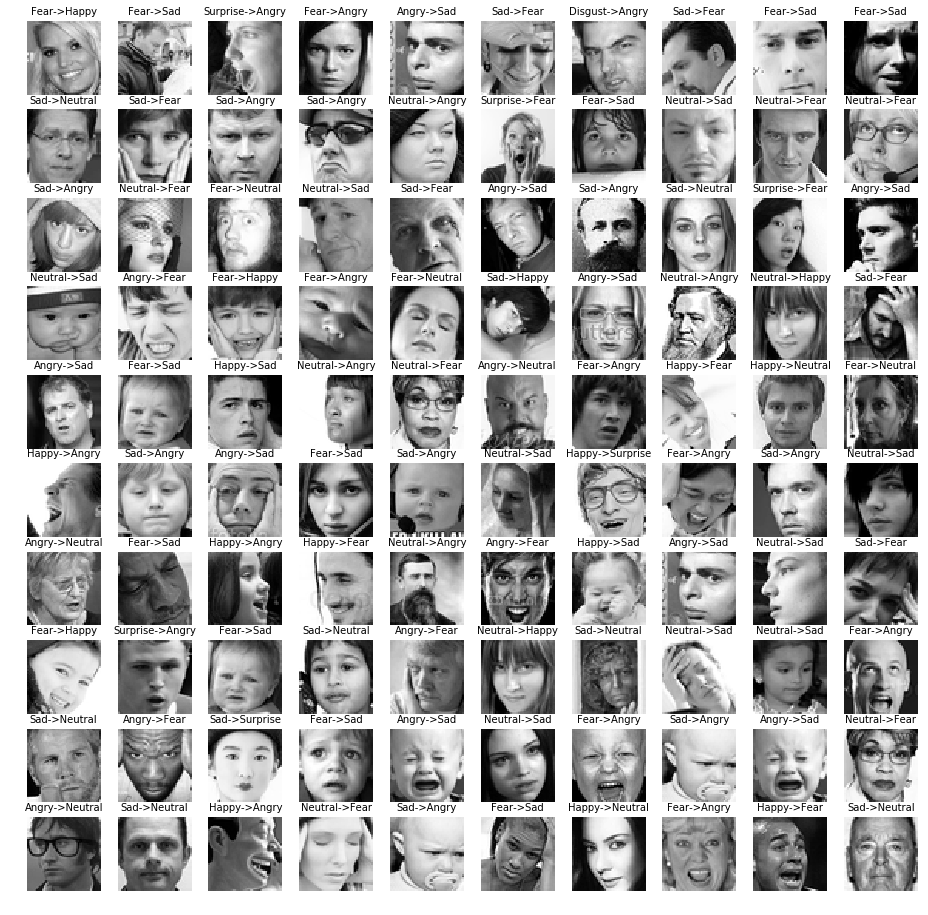

In [76]:
np.random.seed(1)

fig = plt.figure(figsize=(16, 16))

rows = 10
cols = 10

for i in range(1, rows * cols + 1):
    idx = np.random.randint(0, len(images))
    
    fig.add_subplot(rows, cols, i)
    image = np.array(images[idx], dtype=float)
    plt.imshow(image.reshape((48, 48)), cmap = 'gray')
    plt.title(str(misclassified.loc[idx, 'true']) + "->" + str(misclassified.loc[idx, 'pred']), 
              fontdict = {'fontsize': 10, 'color': "black"})
    plt.axis('off')
plt.show()

### Confusion matrices

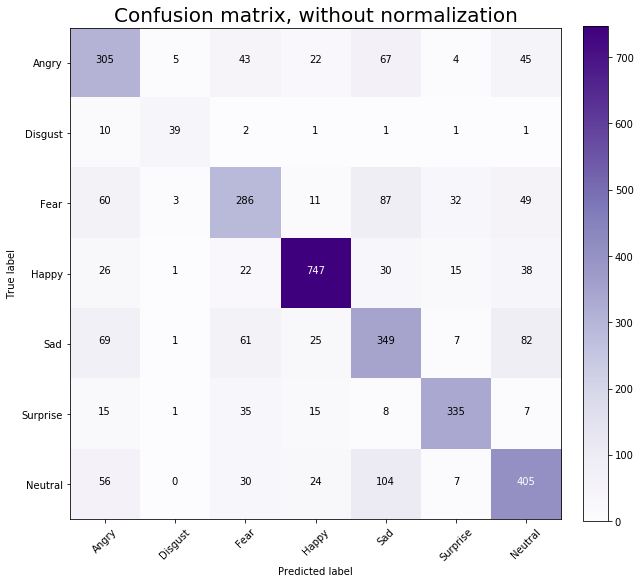

In [77]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y['true'], y['pred'],
                              labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

np.set_printoptions(precision=2)

plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      title='Confusion matrix, without normalization', cmap = 'Purples')

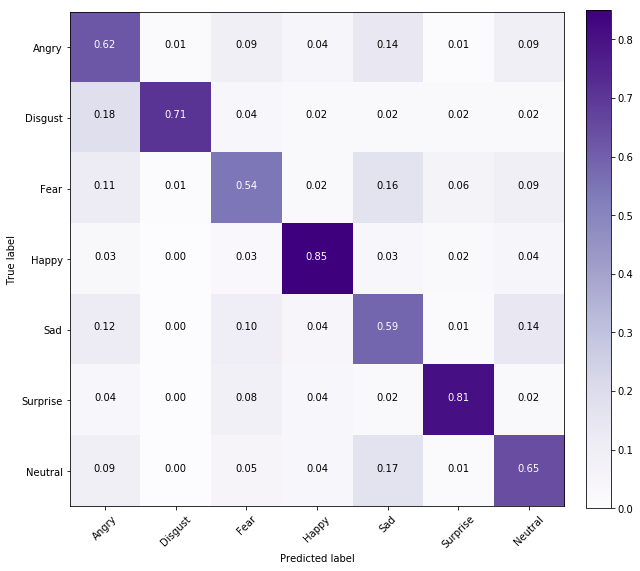

In [78]:
plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      normalize=True,
                      title='', cmap = 'Purples')